# Imports

In [103]:
import xarray as xr
from xarray.groupers import UniqueGrouper
import numpy as np
import xeofs as xe
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf
import cartopy.util as cutil
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

In [104]:
ds = xr.open_dataset('/glade/work/acruz/CESM21SSTs.nc')

In [177]:
ds

<xarray.Dataset> Size: 27GB
Dimensions:  (lat: 192, lon: 288, time: 1212, member: 100)
Coordinates:
  * lat      (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon      (lon) float64 2kB 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 10kB 1914-01-01 00:00:00 ... 2014-12-01 00:00:00
Dimensions without coordinates: member
Data variables:
    SST      (member, time, lat, lon) float32 27GB ...

# Data select

In [181]:
%%time
# time = 101 years * 12 months = 1,212
# ds = ds.sel(time=slice('1914-01-01', '2014-12-01'))
ds = ds.sel(time=slice('1920-01-01', '2014-12-01'))
# Easier and faster to shift lons to -180, 180
ds.coords['lon'] = (ds.coords['lon'] + 180) % 360 - 180
ds = ds.sortby(ds.lon)

# roll data and then assign coords, to avoid using where
ATL_ds = ds.sel(lat=slice(-10, 10), lon=slice(-60, 20))


ATL_ds

CPU times: user 5.99 ms, sys: 0 ns, total: 5.99 ms
Wall time: 6.03 ms


<xarray.Dataset> Size: 652MB
Dimensions:  (lat: 22, time: 1140, member: 100, lon: 65)
Coordinates:
  * lat      (lat) float64 176B -9.895 -8.953 -8.01 -7.068 ... 8.01 8.953 9.895
  * time     (time) object 9kB 1920-01-01 00:00:00 ... 2014-12-01 00:00:00
  * lon      (lon) float64 520B -60.0 -58.75 -57.5 -56.25 ... 17.5 18.75 20.0
Dimensions without coordinates: member
Data variables:
    SST      (member, time, lat, lon) float32 652MB ...

# Anomalies

In [182]:
clim = ATL_ds.groupby('time.month').mean(dim='time')

In [183]:
anom = ATL_ds.groupby('time.month') - clim

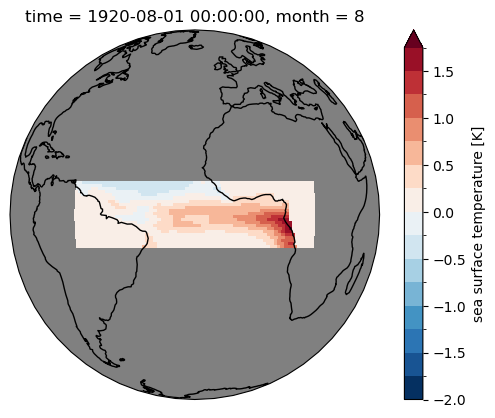

In [184]:
# quick test plot
p = anom['SST'].isel(member=5, time=7).plot(
    subplot_kws=dict(projection=ccrs.Orthographic(-20, 0), facecolor="gray"),
    transform=ccrs.PlateCarree(), levels=np.arange(-2, 2, 0.25)
)
p.axes.set_global()

p.axes.coastlines()

# Detrend
Remove later if we decide on it

In [185]:
def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit


anom_dtrend = detrend_dim(anom['SST'], dim='time')

# EOF

In [186]:
anom_members = [anom_dtrend.sel(member=m) for m in anom_dtrend['member']]
anom_members

[<xarray.DataArray (time: 1140, lat: 22, lon: 65)> Size: 13MB
 array([[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         ...,
         [ 0.6805753 ,  0.65181556,  0.58676434, ...,  0.        ,
           0.        ,  0.        ],
         [ 0.68887141,  0.59478265,  0.53873512, ...,  0.        ,
           0.        ,  0.        ],
         [ 0.63193615,  0.51394545,  0.4912756 , ...,  0.        ,
           0.        ,  0.        ]],
 
        [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,

In [187]:
%%time
'''
Members are not kept separate from decomposoition and its loosing the dimension after the fit

model.scores() not returning list of DataArray in same way as model.components
from source code the type annotation is dataarray instead of DataObject

as alternative I will simply loop through members and call a  new fit everytime
'''
EOF_members = []
for m in anom_members:
    model = xe.single.EOF(n_modes=3, use_coslat=True)
    model.fit(anom_members[0], dim='time')
    components = model.components()
    PCs = model.scores(normalized=False)
    xplained_var = model.explained_variance_ratio().values
    EOF_members.append({'components' : components,
                        'PCs' : PCs,
                        'xplained_var' : xplained_var})

CPU times: user 7.2 s, sys: 946 μs, total: 7.21 s
Wall time: 7.48 s


# Scaling and normalizing

In [188]:
# normalized PCs
nPCs_members = []
# scaled EOFs
sEOF_members = []
for m in EOF_members:
    pc_std = m['PCs'].std()
    pc_mean = m['PCs'].mean()
    
    normalized_PCs = (PCs - pc_mean) / pc_std
    scaled_EOF = components * pc_std
    
    nPCs_members.append(normalized_PCs)
    sEOF_members.append(scaled_EOF)

# CANI and EANI

In [189]:
EANI_members = []
CANI_members = []
E_pattern_members = []
C_pattern_members = []

for PC, EOF in zip(nPCs_members, sEOF_members):
    
    PC1 = PC.sel(mode=1)
    PC3 = PC.sel(mode=3)

    EOF1 = EOF.sel(mode=1)
    EOF3 = EOF.sel(mode=3)

    EAN = (EOF1 + EOF3) / (2 ** 0.5)
    CAN = (EOF1 - EOF3) / (2 ** 0.5)
    
    EANI = (PC1 + PC3) / (2 ** 0.5)
    CANI = (PC1 - PC3) / (2 ** 0.5)

    # using 5 months as in literature
    roll = 5
    EANI_roll = EANI.rolling(time=roll, center=True).mean()
    CANI_roll = CANI.rolling(time=roll, center=True).mean()

    EANI_members.append(EANI_roll)
    CANI_members.append(CANI_roll)
    E_pattern_members.append(EAN)
    C_pattern_members.append(CAN)

In [190]:
E_pattern_members[0]

<xarray.DataArray (lat: 22, lon: 65)> Size: 11kB
array([[-3.55956571e-16,  7.71716736e-16, -5.11726731e-16, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 1.90644239e-01,  1.75740584e-01,  1.68045878e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.90064505e-01,  1.78079770e-01,  1.55298250e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.83748786e-01,  1.66643044e-01,  1.46796883e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])
Coordinates:
  * lat      (lat) float64 176B -9.895 -8.953 -8.01 -7.068 ... 8.01 8.953 9.895
  * lon      (lon) float64 520B -60.0 -58.75 -57.5 -56.25 ... 17.5 18.75 20.0
Attributes: (12/15)
    model:          EOF analysis
    software:       xeofs
    version:        3.0.4
    date:           2025-07-02 15:10:36
    n_modes:        3
    center:         True
    ...             ...
    sample_name:    sample
    feature_name:   feature
    random_state:   None
    compute:        True
    solver:         auto
    solver_kwargs:  {}

# Variances

In [191]:
def CvE_r(EANI_roll, CANI_roll):
    # select only the summer of the index
    EANI_JJA = EANI_roll.where(EANI_roll.time.dt.month.isin([6, 7, 8]), drop=True)
    CANI_JJA = CANI_roll.where(CANI_roll.time.dt.month.isin([6, 7, 8]), drop=True)
    
    EANI_JJA_mean = EANI_JJA.groupby(EANI_JJA.time.dt.year).mean()
    CANI_JJA_mean = CANI_JJA.groupby(CANI_JJA.time.dt.year).mean()
    var_roll = 21
    
    EANI_var = EANI_JJA_mean.rolling(year=var_roll, center=True).var()
    CANI_var = CANI_JJA_mean.rolling(year=var_roll, center=True).var()
    
    CvE_r = CANI_var / EANI_var

    return {'EANI': EANI_var, 'CANI': CANI_var, 'C/E_Ratio': CvE_r}

CvE_members = []
for E, C in zip(EANI_members, CANI_members):
    CvE_members.append(CvE_r(E, C))

In [192]:
CvE_members

[{'EANI': <xarray.DataArray 'scores' (year: 95)> Size: 760B
  array([       nan,        nan,        nan,        nan,        nan,
                nan,        nan,        nan,        nan,        nan,
         0.58118891, 0.55006277, 0.55214142, 0.56980389, 0.57552424,
         0.58593607, 0.78148791, 0.77889723, 0.75407189, 0.78121312,
         0.7819332 , 0.77615618, 0.78983053, 0.8779119 , 0.88662207,
         0.82103055, 0.82192108, 0.76382891, 0.80441525, 0.86387762,
         0.82985409, 0.84167057, 1.07070829, 1.44784293, 1.53744237,
         1.60412447, 1.61676373, 1.14903841, 1.14921999, 1.15092873,
         1.01629586, 0.86473073, 0.83177891, 0.83733995, 0.86213808,
         0.9111788 , 0.88415987, 0.93586756, 0.93659065, 0.93621107,
         0.94018671, 0.8450901 , 1.01076489, 0.90965089, 0.6483772 ,
         0.54330987, 0.49729829, 0.49388286, 0.53311645, 0.776269  ,
         0.77252151, 0.81465298, 0.80520437, 0.80234487, 0.88854984,
         0.89191355, 0.78838962, 0.78601033

# Plotting

In [199]:
# join members in same da to calculate mean easier
EAN_patterns = xr.concat(E_pattern_members, dim='member')
CAN_patterns = xr.concat(C_pattern_members, dim='member')
EOFs_da = xr.concat(sEOF_members, dim='member')

### View data

In [215]:
EAN_patterns

<xarray.DataArray (member: 100, lat: 22, lon: 65)> Size: 1MB
array([[[-3.55956571e-16,  7.71716736e-16, -5.11726731e-16, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        ...,
        [ 1.90644239e-01,  1.75740584e-01,  1.68045878e-01, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 1.90064505e-01,  1.78079770e-01,  1.55298250e-01, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 1.83748786e-01,  1.66643044e-01,  1.46796883e-01, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

       [[-3.55956571e-16,  7.71716736e-16, -5.11726731e-16, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
...
        [ 1.90644239e-01,  1.75740584e-01,  1.68045878e-01, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 1.90064505e-01,  1.78079770e-01,  1.55298250e-01, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 1.83748786e-01,  1.66643044e-01,  1.46796883e-01, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

       [[-3.55956571e-16,  7.71716736e-16, -5.11726731e-16, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        ...,
        [ 1.90644239e-01,  1.75740584e-01,  1.68045878e-01, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 1.90064505e-01,  1.78079770e-01,  1.55298250e-01, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 1.83748786e-01,  1.66643044e-01,  1.46796883e-01, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]]])
Coordinates:
  * lat      (lat) float64 176B -9.895 -8.953 -8.01 -7.068 ... 8.01 8.953 9.895
  * lon      (lon) float64 520B -60.0 -58.75 -57.5 -56.25 ... 17.5 18.75 20.0
Dimensions without coordinates: member
Attributes: (12/15)
    model:          EOF analysis
    software:       xeofs
    version:        3.0.4
    date:           2025-07-02 15:10:36
    n_modes:        3
    center:         True
    ...             ...
    sample_name:    sample
    feature_name:   feature
    random_state:   None
    compute:        True
    solver:         auto
    solver_kwargs:  {}

In [212]:
EOF_members[0]['xplained_var']

array([0.61765888, 0.13564198, 0.05361122])

## Map function

In [204]:
def ds_map(ds_to_plt, bounds=[20, -60, 10, -10], name='figure'):
    fig, ax = plt.subplots(1, 1,
                           subplot_kw={'projection': ccrs.PlateCarree()})
    fig.subplots_adjust(hspace=0, wspace=0, top=0.925, left=0.1)
    cbar_ax = fig.add_axes([0, 0, 0.1, 0.1])
    cdat, clon = cutil.add_cyclic_point(ds_to_plt, ds_to_plt.lon)

    ax.set_title(name)
    lat_ticks = np.arange(bounds[3], bounds[2], 5)
    lon_ticks = np.arange(bounds[1], bounds[0], 10)
    ax.set_xticks(lon_ticks, crs=ccrs.PlateCarree())
    ax.set_yticks(lat_ticks, crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.add_feature(cf.LAND)


    def resize_colobar(event):
        plt.draw()
        posn = ax.get_position()
        cbar_ax.set_position([posn.x0 + posn.width + 0.01, posn.y0,
                              0.04, posn.height])

    ax.set_extent(bounds, ccrs.PlateCarree())
    sst_contour = ax.contourf(clon, ds_to_plt.lat, cdat,
                              levels=np.arange(-0.4, 0.5, 0.05),
                              # levels=40,
                              transform=ccrs.PlateCarree(), cmap='inferno', extend='both')
    fig.canvas.mpl_connect('resize_event', resize_colobar)
    ax.coastlines()
    plt.colorbar(sst_contour, cax=cbar_ax)
    resize_colobar(None)
    # plt.savefig(name, dpi=300)
    plt.show()

## EANI Pattern

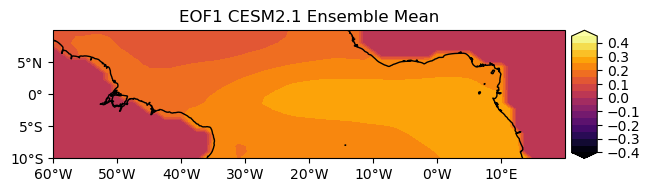

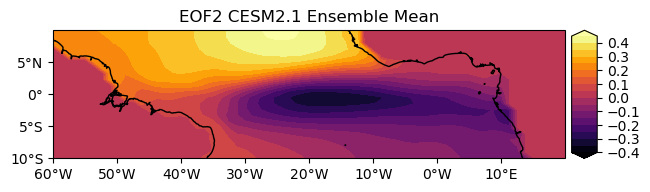

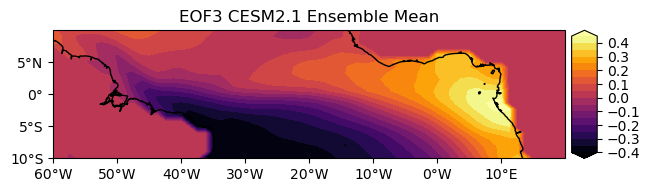

In [206]:
# mean EOF1, EOF2, EOF3 on ensemble to compare
ens_mean_EOF1 = EOFs_da.sel(mode=1).mean(dim='member')
ens_mean_EOF2 = EOFs_da.sel(mode=2).mean(dim='member')
ens_mean_EOF3 = EOFs_da.sel(mode=3).mean(dim='member')

ds_map(ens_mean_EOF1, name='EOF1 CESM2.1 Ensemble Mean')
ds_map(ens_mean_EOF2, name='EOF2 CESM2.1 Ensemble Mean')
ds_map(ens_mean_EOF3, name='EOF3 CESM2.1 Ensemble Mean')

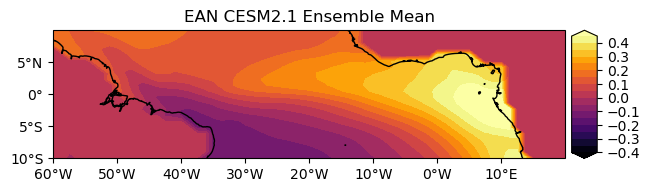

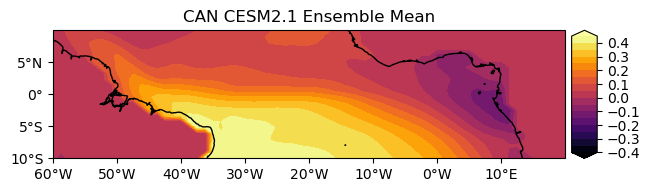

In [214]:
# mean ensemble pattern
ens_mean_EAN = EAN_patterns.mean(dim='member')
ens_mean_CAN = CAN_patterns.mean(dim='member')

ds_map(ens_mean_EAN, name='EAN CESM2.1 Ensemble Mean')
ds_map(ens_mean_CAN, name='CAN CESM2.1 Ensemble Mean')

## Variance

In [174]:
# Eastern and central plot including all members and ensemble mean

In [175]:
# ensemble mean of eastern with ensemble mean of central through time